In [1]:
import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf, ListConfig
from dotenv import load_dotenv
from time import sleep
from tqdm import tqdm
import numpy as np
import pandas as pd
import wandb
import os
import seaborn as sns

from typing import Optional, List, Tuple

from huggingface_hub import snapshot_download
from transformers import AutoTokenizer

import spacy
from spacy.tokens import Span, Doc
from spacy import displacy
from spacy.lang.en import English

import numpy as np
from IPython.core.display import display, HTML

/home/ionov/anaconda3/envs/kaggle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3623657/1372196912.py:24: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# init hydra config

initialize(version_base=None, config_path="../conf/", job_name="rewriting")
cfg = compose(config_name="generation_conf")

In [3]:
print(cfg)

{'input_data_path': None, 'output_path': '../data/essay/rewritten.json', 'original_essays_path': '../data/essay/og_train.json', 'prompt_path': '../conf/prompts/rewriting_prompt_v1.txt', 'n_samples': 3000, 'sampling_params': {'max_tokens': 4000, 'n': 1, 'temperature': 1, 'top_k': 200}, 'engine': {'model': 'TheBloke/Mixtral-8x7B-Instruct-v0.1-GPTQ', 'tensor_parallel_size': 1, 'enable_lora': False, 'enforce_eager': False, 'quantization': 'gptq', 'gpu_memory_utilization': 0.8, 'dtype': 'float16'}, 'wandb': {'entity': 't-ionov', 'project': 'PII', 'run_name': 'mixtral rewriting', 'job_type': 'llm-inference'}}


In [4]:
wandb_cfg = cfg.wandb
os.environ["WANDB_PROJECT"] = wandb_cfg.project
os.environ["WANDB_ENTITY"] = wandb_cfg.entity
os.environ["WANDB_JOB_TYPE"] = wandb_cfg.job_type
os.environ["WANDB_LOG_MODEL"] = "false"
os.environ["WANDB_WATCH"] = "all"

os.environ["HYDRA_FULL_ERROR"] = "1"

# Data generation

Below you can see the prompt we will be using for rewriting essays

In [5]:
# Read promt_format
with open(cfg.prompt_path, "r") as file:
    prompt_format = file.read()
    print(prompt_format.format("\'original essay\'", "\'PII entities\'"))

'original essay'

Task description: You are given a text that lacks specific personal information identifiers (PII). Your task is to rewrite the above essay by adding all the personal information listed below, while preserving the naturalness and integrity of the text.

'PII entities'

Requirements:

- Make sure to mention all of the examples of personal information in generated essay
- Add entity in such a way that it seamlessly integrates into the context and does not seem overly intrusive or out of place.
- Distribute personal information evenly throughout the essay, do not stack it all in one place.


Create requests for the engine with variable **entity types** and **sampling parameters**

In [6]:
from itertools import combinations

PII_ENTS = [
  ("name", "NAME_STUDENT", "James Brown"),
  ("email", "EMAIL", "example@email.com"),
  ("personal_url", "URL_PERSONAL", "https://example.com"),
  ("username", "USERNAME", "john42"),
  ("address", "STREET_ADDRESS", "221B, Baker Street, London"),
  ("phone_num", "PHONE_NUM", "+1 212 555 0188"),
  ("userid", "ID_NUM", "123456789")
]

ENT_COMBINATIONS = [
   *[(ent,) for ent in PII_ENTS],
   *[(PII_ENTS[0], ent) for ent in PII_ENTS],
   *[comb for comb in combinations(PII_ENTS[:4], 3)]
]
ENT_COMBINATIONS = np.array(ENT_COMBINATIONS, dtype='object')

In [7]:
def sample_ent_combination():
    return np.random.choice(ENT_COMBINATIONS, p=None)

In [8]:
def dict2str(d):
    return "\n".join([f"{k}={v}" for k, v in d.items()])

In [9]:
def build_request(prompt_format, ent_combination, essay=None):
  ents_to_generate = {ent_type: [ent_text] for ent_description, ent_type, ent_text in ent_combination}
  pii_str = "\n".join([f"{ent_description}={ent_text}" for ent_description, ent_type, ent_text in ent_combination]) 
  prompt = prompt_format.format(pii_str, "") if essay is None else prompt_format.format(essay, pii_str)

  request = {
    "prompt": prompt,
    "ents_to_generate": ents_to_generate,
  }
  return request

In [10]:
def create_requests(essays) -> list[dict]:
    essays = [None] if essays is None else essays
    generation_requests = []
    for essay in essays:
      ent_combination = sample_ent_combination()
      request = build_request(prompt_format, ent_combination, essay)
      generation_requests.append(request)

    return generation_requests

In [11]:
# Read essays for rewriting
orig_essays_df = pd.read_json(cfg.original_essays_path)

In [12]:
orig_essays_df.shape

(5117, 28)

In [13]:
labels = [t for l in orig_essays_df.labels.values for t in l]

In [14]:
set(labels)

{'B-EMAIL',
 'B-ID_NUM',
 'B-NAME_STUDENT',
 'B-URL_PERSONAL',
 'I-NAME_STUDENT',
 'I-URL_PERSONAL',
 'O'}

In [15]:
essays_with_pii = orig_essays_df[orig_essays_df.labels.apply(lambda x: set(["O", "B-NAME_STUDENT"]).issubset(set(x)))]
orig_essays_df =  orig_essays_df[orig_essays_df.labels.apply(lambda x: set(x) == set(["O"]))]
essays = orig_essays_df["full_text"].tolist()[:cfg.n_samples]

In [19]:
generation_requests = create_requests(essays)

In [20]:
len(generation_requests)

3000

# vllm call

In [21]:
def initialize_engine(cfg) -> LLMEngine:
    engine_args = EngineArgs(**cfg.engine)
    return LLMEngine.from_engine_args(engine_args)

def process_requests(engine, generation_requests):
    """Continuously pro cess a list of prompts and handle the outputs."""

    generated_examples = []
    for request_id, request_data in enumerate(generation_requests):

        prompt = request_data["prompt"]
        sampling_params = SamplingParams(**request_data["sampling_params"])
        lora_request = None if not request_data["lora_params"] else LoRARequest(**request_data["lora_params"])

        engine.add_request(str(request_id), prompt, sampling_params, lora_request)


    while engine.has_unfinished_requests():
        request_outputs = engine.step()
        for request_output in request_outputs:
            if request_output.finished:
                for output in request_output.outputs:
                    generated_text = output.text
                    request_data = generation_requests[int(request_output.request_id)]
                    generated_examples.append({"generated_text": generated_text, **request_data})
    return generated_examples

In [22]:
engine = initialize_engine(cfg)    
generated_examples = process_requests(engine, generation_requests)


WARNING 03-31 22:21:19 config.py:618] Casting torch.bfloat16 to torch.float16.
WARNING 03-31 22:21:19 config.py:193] gptq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 03-31 22:21:19 llm_engine.py:87] Initializing an LLM engine with config: model='TheBloke/Mixtral-8x7B-Instruct-v0.1-GPTQ', tokenizer='TheBloke/Mixtral-8x7B-Instruct-v0.1-GPTQ', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=32768, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=gptq, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)
libibverbs: Warning: couldn't open config directory '/etc/libibverbs.d'.
INFO 03-31 22:21:25 weight_utils.py:163] Using model weights format ['*.safetensors']
INFO 03-31 22:22:01 llm_engine.py:357] # GPU blocks: 2438, # CPU blocks: 2048
INFO 03-31 22:22:03 model_runner.py:684] Capturing the mo

In [23]:
# generation_requests = np.array(generation_requests)

In [24]:
df = pd.DataFrame().from_records(generated_examples)

In [33]:
# from ast import literal_eval
# df = pd.read_csv('../data/essay/gpt35.csv')
# df['ents_to_generate'] = df['ents_to_generate'].apply(lambda x: literal_eval(x))

Convert df to appropriate format

In [34]:
generation_df = df.rename(columns={"ents_to_generate": "label_dict"})
generation_df

,generated_text,prompt,label_dict
0,Reflection: Storytelling\n\nChallenge As Ja...,Reflection: Storytelling\n\nChallenge I am ...,"{'NAME_STUDENT': ['James Brown'], 'USERNAME': ..."
1,Visualization is a key tool to convey your ide...,Challenge & Selection Visualization is a ke...,"{'NAME_STUDENT': ['James Brown'], 'EMAIL': ['e..."
2,James Brown applied the visualisation tool to ...,Reflection – Visualisation\n\nChallenge and Se...,{'NAME_STUDENT': ['James Brown']}
3,"As a kindergarten teacher, I, John, mainly tea...",Challenge and Selection I am a kindergarten t...,"{'EMAIL': ['example@email.com'], 'URL_PERSONAL..."
4,Design Thinking for Innovation in the Air Tran...,Design Thinking for Innovation in the Air Tran...,{'EMAIL': ['example@email.com']}
...,...,...,...
2995,In the process of redesigning the postpaid SR ...,Visualization\n\nChallenge & Selection –\n\nTh...,{'EMAIL': ['example@email.com']}
2996,Updating the map of intersection of functional...,Task\n\nUpdating the map of intersection of fu...,{'NAME_STUDENT': ['James Brown']}
2997,As a member of a work group in my organization...,Reflection – Visualization\n\nChallenge & Sele...,{'NAME_STUDENT': ['James Brown']}
2998,Reflection Exercise – Visualization\n\nChallen...,Reflection Exercise – Visualization\n\nChallen...,"{'EMAIL': ['example@email.com'], 'URL_PERSONAL..."


# Entity detection

In [35]:
UNIQUE_LABELS = {
    "URL_PERSONAL",
    "EMAIL",
    "USERNAME",
    "STREET_ADDRESS",
    "NAME_STUDENT",
    "PHONE_NUM",
    "ID_NUM"
}

LABEL2ENT_SPECIAL_TOKEN = {l : l + "_TOKEN" for l in UNIQUE_LABELS}
ENT_SPECIAL_TOKEN2LABEL = {l + "_TOKEN": l for l in UNIQUE_LABELS}

ENTITY_SPECIAL_TOKENS = set(LABEL2ENT_SPECIAL_TOKEN.values())

### Replace generated ents with class labels

In [36]:
replace_order = [
    "URL_PERSONAL",
    "EMAIL",
    "USERNAME",
    "STREET_ADDRESS",
    "NAME_STUDENT",
    "PHONE_NUM",
    "ID_NUM",
]

def replace_ents_with_labels(row):
    text = row["generated_text"]
    missing_ents_dict = {}
    for ent_label in replace_order:
        if ent_label not in row["label_dict"]:
            continue

        ent = row["label_dict"][ent_label]
        assert len(ent) == 1
        ent_text = ent[0]
        missing_ents_dict[ent_label] = ent_text not in text 
        if not missing_ents_dict[ent_label]:
            text = text.replace(ent_text, LABEL2ENT_SPECIAL_TOKEN[ent_label])

    row["generated_text_with_ent_labels"] = text
    row["missing_ents_dict"] = missing_ents_dict
    return row

generation_df = generation_df.agg(replace_ents_with_labels, axis=1)

### Tokenize generated texts

In [37]:
en_tokenizer = English().tokenizer
    
def tokenize_with_spacy(text, tokenizer=en_tokenizer):
    tokenized_text = tokenizer(text)
    tokens = [token.text for token in tokenized_text]
    trailing_whitespace = [bool(token.whitespace_) for token in tokenized_text]
    return tokens, trailing_whitespace

def tokenize_df_with_spacy(row):
    tokens, trailing_whitespace = tokenize_with_spacy(row["generated_text_with_ent_labels"])
    row["tokens"] = tokens
    row["trailing_whitespace"] = trailing_whitespace
    row["labels"] = ["O"] * len(tokens)
    return row

generation_df = generation_df.agg(tokenize_df_with_spacy, axis=1)

### Find ents positions

In [38]:
def mark_ent_label_tokens(row):
    ent2pos = {x: [] for x in UNIQUE_LABELS}
    tokens = row["tokens"]
    for i, tok in enumerate(tokens):
        if tok in ENTITY_SPECIAL_TOKENS:
            enity_label = ENT_SPECIAL_TOKEN2LABEL[tok]
            ent2pos[enity_label].append(i)
    row["ent2pos"] = ent2pos
    return row

generation_df = generation_df.agg(mark_ent_label_tokens, axis=1)

### Replace labels with ents

In [39]:
def replace_labels_with_ents(row):
    ent2pos = row["ent2pos"]
    ents_dict = row["label_dict"]

    entity_mentions = [(ent_label, ent_text, pos) for ent_label, ent_text in ents_dict.items() for pos in ent2pos[ent_label]]
    sorted_entity_mentions = sorted(entity_mentions, key=lambda x: x[-1], reverse=True)

    for ent_label, ent_text, pos in sorted_entity_mentions:
        assert len(ent_text) == 1
        ent_text = ent_text[0]
        ent_tokens, ent_trailing_whitespace = tokenize_with_spacy(ent_text)
        ent_bio_tags = ["B-" + ent_label] + ["I-" + ent_label] * (len(ent_tokens) - 1)

        assert len(ent_tokens) == len(ent_trailing_whitespace) == len(ent_bio_tags)
            
        for k, v in [("tokens", ent_tokens), ("trailing_whitespace", ent_trailing_whitespace), ("labels", ent_bio_tags)]:
            row[k].pop(pos)
            row[k][pos:pos] = v

    return row

generation_df = generation_df.agg(replace_labels_with_ents, axis=1)

### Sanity checks

In [40]:
len_df = generation_df[["tokens", "trailing_whitespace", "labels"]].applymap(len)
mask = (len_df["tokens"] == len_df["trailing_whitespace"]) & (len_df["tokens"] == len_df["labels"])
assert mask.astype(int).agg("prod") == 1

/tmp/ipykernel_3623657/1926162866.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  len_df = generation_df[["tokens", "trailing_whitespace", "labels"]].applymap(len)


### Analysys of generated data 

In [41]:
word_tokenizer = English().tokenizer

options = {
        "colors": {
            "B-NAME_STUDENT": "aqua",
            "I-NAME_STUDENT": "skyblue",
            "B-EMAIL": "limegreen",
            "I-EMAIL": "lime",
            "B-USERNAME": "hotpink",
            "I-USERNAME": "lightpink",
            "B-ID_NUM": "purple",
            "I-ID_NUM": "rebeccapurple",
            "B-PHONE_NUM": "red",
            "I-PHONE_NUM": "salmon",
            "B-URL_PERSONAL": "silver",
            "I-URL_PERSONAL": "lightgray",
            "B-STREET_ADDRESS": "brown",
            "I-STREET_ADDRESS": "chocolate",
        }
    }


def visualize_ents(tokens, trailing_whitespace, ents):
    doc = Doc(word_tokenizer.vocab, words=tokens, spaces=trailing_whitespace, ents=ents)
    html = displacy.render(doc, style="ent", jupyter=False, options=options)
    return html

row = generation_df.iloc[0]
html = visualize_ents(row["tokens"], row["trailing_whitespace"], row["labels"])
display(HTML(html))

In [42]:
print("Number of entities missing from generated text")

total_ents = generation_df["missing_ents_dict"].apply(lambda x : [k for k, v in x.items()]).explode().value_counts().to_dict()
missing_ents_dict = generation_df["missing_ents_dict"].apply(lambda x : [k for k, v in x.items() if v == True]).explode().value_counts().to_dict()

for k in total_ents.keys():
    print(f"{k} -> {missing_ents_dict[k] if k in missing_ents_dict else 0} out of {total_ents[k]} missing")

Number of entities missing from generated text
NAME_STUDENT -> 16 out of 1872 missing
USERNAME -> 422 out of 849 missing
URL_PERSONAL -> 175 out of 837 missing
EMAIL -> 63 out of 818 missing
STREET_ADDRESS -> 114 out of 338 missing
ID_NUM -> 79 out of 332 missing
PHONE_NUM -> 12 out of 323 missing


In [50]:
print("Most popular enity combinations")
x = generation_df["missing_ents_dict"].apply(lambda x : [k for k, v in x.items() if v == False]).value_counts()
x.head(5)

Most popular enity combinations


missing_ents_dict
[NAME_STUDENT]                         632
[]                                     306
[EMAIL, NAME_STUDENT]                  209
[URL_PERSONAL, NAME_STUDENT]           164
[URL_PERSONAL, EMAIL, NAME_STUDENT]    161
Name: count, dtype: int64

In [51]:
y = generation_df["missing_ents_dict"].apply(lambda x : [k for k, v in x.items()]).explode().value_counts()
sum(y.tolist())
y.head(3)

missing_ents_dict
NAME_STUDENT    1872
USERNAME         849
URL_PERSONAL     837
Name: count, dtype: int64

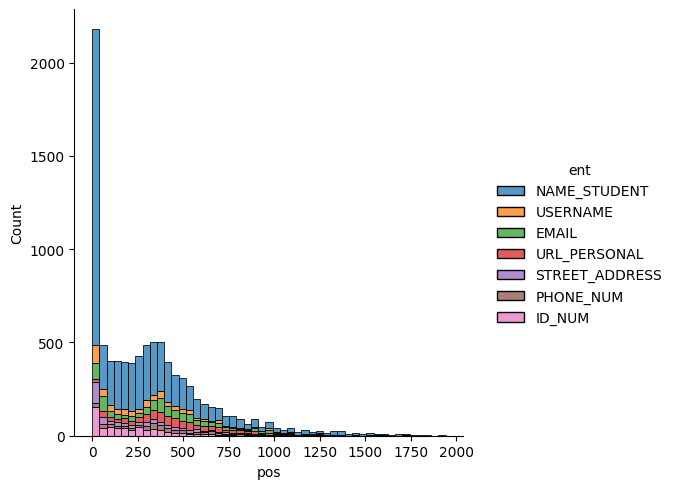

In [52]:
all_ent_pos = []
for ent2pos in generation_df["ent2pos"]:
    for ent, positions in ent2pos.items():
        for pos in positions:
            all_ent_pos.append({"ent": ent, "pos": pos})

ents_pos_distr_df = pd.DataFrame().from_records(all_ent_pos)
sns.displot(ents_pos_distr_df, x="pos", hue="ent", multiple="stack")

# Log generated data

In [53]:
def add_visualization(row):
    html = visualize_ents(row["tokens"], row["trailing_whitespace"], row["labels"])
    row["vizualization"] = wandb.Html(html)
    return row


log_df = generation_df.apply(add_visualization, axis=1)
log_df = log_df[["prompt", 
                 "generated_text", 
                 "generated_text_with_ent_labels", 
                 "vizualization", 
                 "tokens", 
                 "trailing_whitespace", 
                 "labels"]]

missing_ents_normalized = pd.json_normalize(generation_df["missing_ents_dict"])
log_df = pd.concat([log_df, missing_ents_normalized], axis=1)

/home/ionov/anaconda3/envs/kaggle/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)
/home/ionov/anaconda3/envs/kaggle/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)
/home/ionov/anaconda3/envs/kaggle/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recogn

In [54]:
log_df.to_csv('../data/essay/rewritten_logged.csv')

In [55]:
wandb.login()

wandb: Currently logged in as: t-ionov (ods_nlp_course). Use `wandb login --relogin` to force relogin


True

In [56]:
cfg.wandb.run_name

'mixtral rewriting'

In [57]:
with wandb.init(name=cfg.wandb.run_name+"2", job_type=cfg.wandb.job_type) as run:
    table = wandb.Table(dataframe=log_df)
    run.summary["generation_examples_table"] = table

wandb: Currently logged in as: t-ionov. Use `wandb login --relogin` to force relogin
